In [1]:
options(repr.matrix.max.cols=50)

In [2]:
wd <- dirname(dirname(getwd()))
source(paste0(wd,"/mission_control/treasure_map.R"))
source(paste0(wd,"/mission_control/helpers/figures/general.R"))

library(tidyverse)
library(gridExtra)
library(ggpubr)

Loading required package: ggplot2
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  3.1.2     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ dplyr   1.0.6
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  3.1.2     ✔ forcats 0.5.1
Warning message:
“package ‘tibble’ was built under R version 3.6.3”Warning message:
“package ‘tidyr’ was built under R version 3.6.3”Warning message:
“package ‘purrr’ was built under R version 3.6.3”Warning message:
“package ‘dplyr’ was built under R version 3.6.3”Warning message:
“package ‘forcats’ was built under R version 3.6.3”── Conflicts ────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [3]:
library(RColorBrewer)
library(ggborderline)

### 0 - Read the data

In [4]:
base <- readRDS(paste0(TMP_DIR, "validation-ready.Rds"))
shaps <- readRDS(paste0(TMP_DIR, "validation-hmf-preds-pdp.Rds"))

In [5]:
base_go <- 
base %>% 
  select(patient_id, tissue, tmb, tcell, prolif, tgfb, pretreat) %>% 
  mutate(tissue = ifelse(tissue %in% c("bladder", "skin", "lung"), tissue, "other")) %>% 
  drop_na() %>% 
  mutate(tmb = scale(tmb), tcell = scale(tcell), prolif = scale(prolif), 
         tgfb = scale(tgfb), pretreat = scale(pretreat))
base_go <- rbind(base_go, base_go %>% mutate(tissue = "pan"))

In [6]:
ready <- 
  base_go %>% 
    left_join(shaps, by = c("tissue","patient_id"), suffix = c("", "_shap")) %>% 
    drop_na(tcell_shap) %>% 
    mutate(tissue = str_to_title(tissue))

In [7]:
go <- function(i){
    ready %>% 
      select(patient_id, mod, tissue, contains(i)) %>%
      rename(val = !!as.name(i), shap = !!as.name(paste0(i, "_shap"))) %>%
      mutate(feature = i)
}

In [8]:
vamos <- 
  do.call("rbind", 
          list(go("tcell"), go("tmb"), go("prolif"), go("tgfb"), go("pretreat"))) %>% 
  left_join(ready %>% select(patient_id, tissue), by = c("tissue","patient_id")) %>% 
  unique() %>% 
  mutate(tissue = ifelse(tissue == "Pan", "Pan-Cancer (base-model)", tissue))

- Organize features

In [9]:
name_map <- list(
     "pretreat" = "Pretreatment", 
     "prolif" = "Proliferation", 
     "tcell" = "T-cell", 
     "tgfb" = "TGFB", 
     "tmb" = "TMB")

In [10]:
vamos <- vamos %>% rowwise() %>% mutate(feature = factor(name_map[[feature]], levels = c("T-cell", "TMB", "Pretreatment", "TGFB", "Proliferation")))

In [11]:
#vamos %>% group_by(mod) %>% summarise(max(shap), min(shap))

In [12]:
color_map <- list(
    "TMB" = '#80B1D3',
    "T-cell" = '#FB8072',
    "TGFB" = "#BEBADA",
    "Proliferation" = "#8DD3C7",
    "Pretreatment" = "#9E7788"
)

### 1 - Dependence Plots

In [13]:
pdp_plot <- function( df, ylab = "See", k = 2){
    gg <- (
    df %>% 
      ggplot(aes(val, y = shap, color = feature, group = feature)) + 
      scale_color_manual(values=unlist(color_map)) + 
      geom_borderline(size = k, bordercolour = "black") + 
      facet_wrap( ~ tissue, ncol = 2) + 
      labs(x = "Scaled Feature Values") + 
      scale_x_continuous( breaks = seq(-3,3,3), limits = c(-3,3))
    ) 
    if( grepl("BOR",ylab)) {
      gg <- gg + scale_y_continuous(breaks = c(-1,0,1), lim = c(-1.3,1.42) ) + labs(y = ylab)  
    } else {
      gg <- gg + scale_y_continuous(breaks = c(-1,0,1), lim = c(-1.2,1.01)) + labs(y = ylab)    
    }
    gg
}

In [14]:
p1 <- pdp_plot(vamos %>% filter(mod == "lr", tissue == "Pan-Cancer (base-model)"), k = 2, ylab = "BOR Shapley Values")
p2 <- pdp_plot(vamos %>% filter(mod == "lr", tissue %in% c("Skin", "Lung")), k = 1, ylab = "BOR Shapley Values")
p3 <- pdp_plot(vamos %>% filter(mod == "lr", tissue %in% c("Bladder", "Other")), k = 1, ylab = "BOR Shapley Values")
p4 <- pdp_plot(vamos %>% filter(mod == "os", tissue == "Pan-Cancer (base-model)"), k = 2, ylab = "OS Shapley Values")
p5 <- pdp_plot(vamos %>% filter(mod == "os", tissue %in% c("Skin", "Lung")), k = 1, ylab = "OS Shapley Values")
p6 <- pdp_plot(vamos %>% filter(mod == "os", tissue %in% c("Bladder", "Other")), k = 1, ylab = "OS Shapley Values")

### 2 - Importance Plots

In [15]:
importance_plot <- function( df , theme, size ) {
    p <- (
        ggplot(df, aes(x=feature, y = vals, fill = feature))     
            + geom_bar(stat="identity", position = "dodge", color = "black")
            + scale_fill_manual(values=unlist(color_map))
            + facet_wrap( ~ dataset, ncol = 2) 
            + labs(y = "", x = "")  
            + theme
            + geom_text(aes(label=round(vals,1)),color="black", size=size, vjust=-.2)
    )
    if( "Pan-Cancer (base-model)" %in% df$dataset){
        p + scale_y_continuous(breaks = 0, lim = c(0,max(3*df$vals)))  
    } else {
        p + scale_y_continuous(breaks = 0, lim = c(0,max(1.5*df$vals)))  
    }
}

In [16]:
importance <- (
  vamos
    %>% group_by(mod, tissue, feature) 
    %>% summarise(vals = sd(shap))
    %>% ungroup()
)

`summarise()` has grouped output by 'mod', 'tissue'. You can override using the `.groups` argument.


In [17]:
importance_plot <- function (df, theme, size = 5) {
    p <- 
      ggplot(df, aes(x = feature, y = vals, fill = feature)) + 
        geom_bar(stat = "identity", position = "dodge", color = "black") + 
        scale_fill_manual(values = unlist(color_map)) + 
        facet_wrap(~tissue, ncol = 2) + 
        labs(y = "", x = "") + 
        geom_text(aes(label = round(vals, 1)), color = "black", size = size, vjust = -0.2)
    if ("Pan-Cancer (base-model)" %in% df$dataset) {
        p + scale_y_continuous(breaks = 0, lim = c(0, max(3 * df$vals)))
    } else {
        p + scale_y_continuous(breaks = 0, lim = c(0, max(1.5 * df$vals)))
    }
}

In [18]:
i1 <- importance_plot(importance %>% filter(mod == "lr", tissue == "Pan-Cancer (base-model)"))
i2 <- importance_plot(importance %>% filter(mod == "lr", tissue %in% c("Skin","Lung")), size = 3)
i3 <- importance_plot(importance %>% filter(mod == "lr", tissue %in% c("Bladder","Other")), size = 3)
i4 <- importance_plot(importance %>% filter(mod == "os", tissue == "Pan-Cancer (base-model)"))
i5 <- importance_plot(importance %>% filter(mod == "os", tissue %in% c("Skin","Lung")), size = 3)
i6 <- importance_plot(importance %>% filter(mod == "os", tissue %in% c("Bladder","Other")), size = 3)

Warning message:
“Unknown or uninitialised column: `dataset`.”Warning message:
“Unknown or uninitialised column: `dataset`.”Warning message:
“Unknown or uninitialised column: `dataset`.”Warning message:
“Unknown or uninitialised column: `dataset`.”Warning message:
“Unknown or uninitialised column: `dataset`.”Warning message:
“Unknown or uninitialised column: `dataset`.”

### 3 - Combine Plots

- Themes

In [19]:
base_theme <- theme_classic(base_size = 21) 
theme_pdp <- (
    base_theme + 
    theme(axis.title.x=element_blank(), 
          legend.position="none",
          plot.margin = unit(c(0,0,0,0), "cm"))
)
theme_pdp_main <- theme_pdp
theme_pdp_tissue <- (
    theme_pdp + 
    theme(axis.text.x=element_blank(), 
          axis.title.y=element_blank(), 
          axis.text.y=element_blank())
)
theme_bars <- (
    theme_pdp + 
    theme ( axis.ticks.x = element_blank(),
            axis.text.x = element_blank(),
            strip.background = element_blank(), 
            strip.text.x = element_blank())
)
theme_bars_main <- theme_bars 
theme_bars_tissue <- (
    theme_bars + 
    theme(axis.text.x=element_blank(), 
          axis.title.y=element_blank(), 
          axis.text.y=element_blank())
)

- layout

In [20]:
### plot layouts 
layout_main <- rbind( c(1,2), c(1,3))
layout_individual <- rbind( c(1,1), c(1,1), c(1,1), c(1,1), c(2,2))

- Juntos!

In [21]:
o1 <- arrangeGrob(p1 + theme_pdp_main , i1 + theme_bars_main , layout_matrix = layout_individual) 
o2 <- arrangeGrob(p2 + theme_pdp_tissue, i2 + theme_bars_tissue, layout_matrix = layout_individual) 
o3 <- arrangeGrob(p3 + theme_pdp_tissue, i3 + theme_bars_tissue, layout_matrix = layout_individual) 
l_o <- arrangeGrob(o1, o2, o3, layout_matrix = layout_main)

ll_ready <- get_dressed(l_o, title = "HMF Shapley Values - Response", size = 21)

o4 <- arrangeGrob(p4 + theme_pdp_main, i4 + theme_bars_main, layout_matrix = layout_individual) 
o5 <- arrangeGrob(p5 + theme_pdp_tissue, i5 + theme_bars_tissue, layout_matrix = layout_individual) 
o6 <- arrangeGrob(p6 + theme_pdp_tissue, i6 + theme_bars_tissue, layout_matrix = layout_individual) 
o_o <- arrangeGrob(o4, o5, o6, layout_matrix = layout_main)

oo_ready <- get_dressed(o_o, title = "HMF Shapley Values - Overall Survival", size = 21)

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”Warning message:
“Removed 1 row(s) containing missing values (geom_path).”Warning message:
“Removed 1 row(s) containing missing values (geom_path).”Warning message:
“Removed 1 row(s) containing missing values (geom_path).”

In [22]:
options(repr.plot.width = 10, repr.plot.height = 10)
lets_go <- as_ggplot(arrangeGrob(ll_ready, oo_ready, ncol = 1))

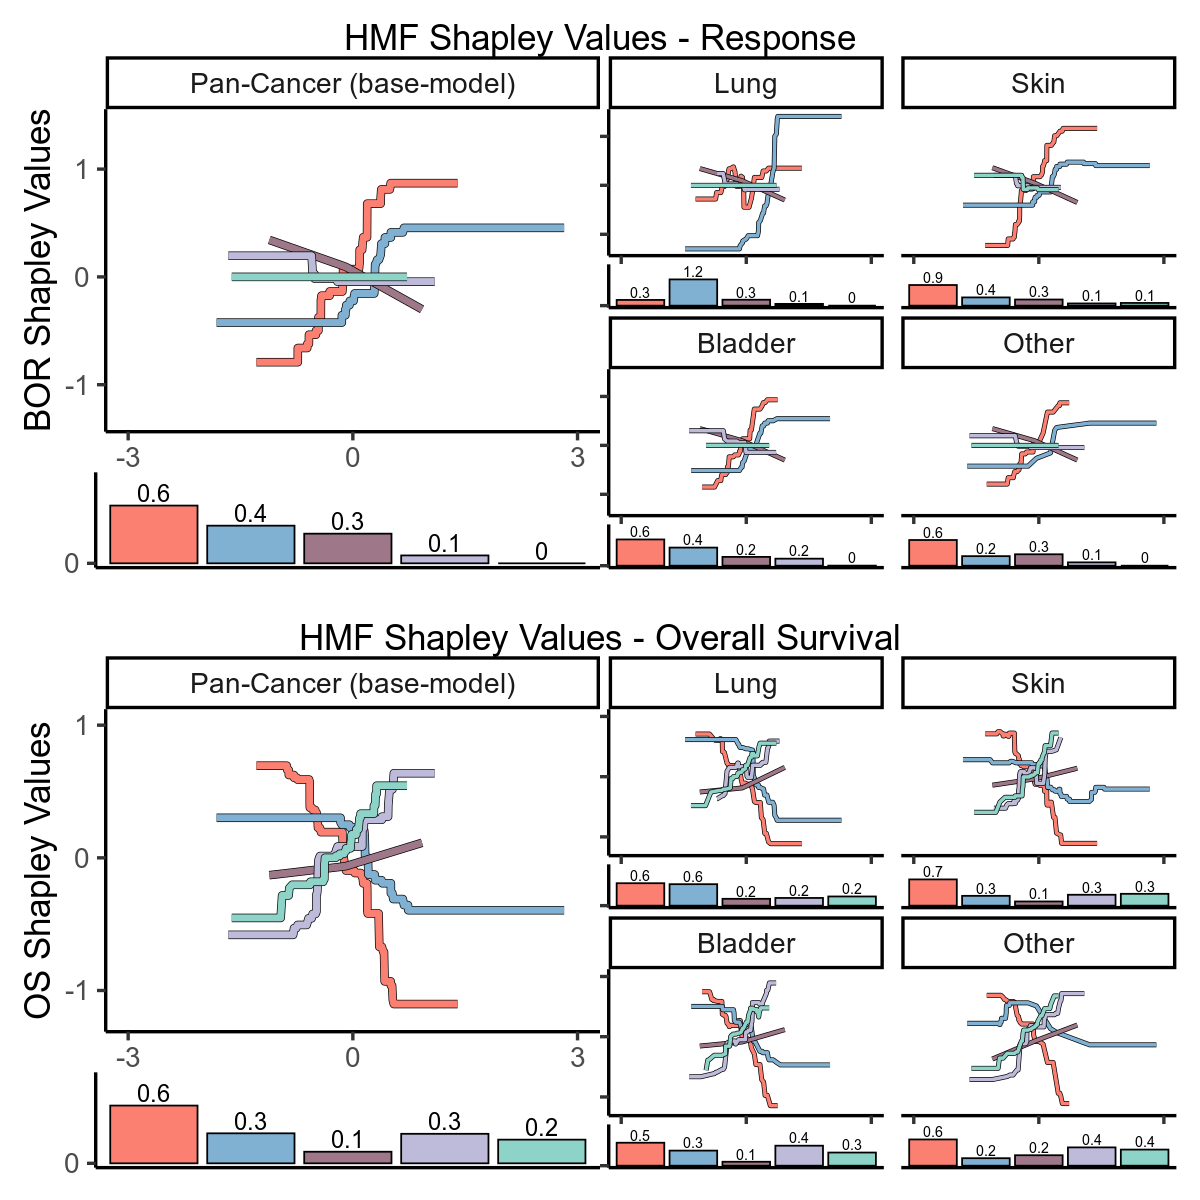

In [23]:
lets_go

In [24]:
ggsave( paste0(FIG_DIR, "5b_shapley_pdp.png"), width = 10, height = 10, dpi = 300)

In [25]:
paste0(FIG_DIR, "5b_shapley_pdp.png")

[1] "/workspace/projects/immune_biomarkers/tmp_figures/5b_shapley_pdp.png"